In [1]:
!pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

### Downloading dataset from Kaggle

In [5]:
! kaggle datasets download jangedoo/utkface-new

 98% 324M/331M [00:07<00:00, 32.1MB/s]
100% 331M/331M [00:07<00:00, 43.7MB/s]


### Unzipping the dataset

In [6]:
!unzip utkface-new.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [7]:
dataset_folder_name = 'utkface_aligned_cropped/UTKFace'

TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())


In [8]:
print(dataset_dict)

{'race_id': {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}, 'gender_id': {0: 'male', 1: 'female'}, 'gender_alias': {'male': 0, 'female': 1}, 'race_alias': {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4}}


### Importing Libraries

In [3]:
import numpy as np 
import pandas as pd
import random
import cv2
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Utility Function to parse the dataset

In [10]:
def parse_dataset(dataset_path, ext='jpg'):

    def parse_info_from_file(path):
        
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    # print(files)
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()
    
    return df

### Data Exploration

In [11]:
df = parse_dataset(dataset_folder_name)
df.head()

,age,gender,race,file
0,49.0,male,indian,utkface_aligned_cropped/UTKFace/49_0_3_2017011...
1,55.0,male,indian,utkface_aligned_cropped/UTKFace/55_0_3_2017011...
2,26.0,female,indian,utkface_aligned_cropped/UTKFace/26_1_3_2017010...
3,26.0,female,indian,utkface_aligned_cropped/UTKFace/26_1_3_2017010...
4,26.0,male,asian,utkface_aligned_cropped/UTKFace/26_0_2_2017011...


In [12]:
df.shape

(23705, 4)

### Random data sample visualization

(200, 200, 3)


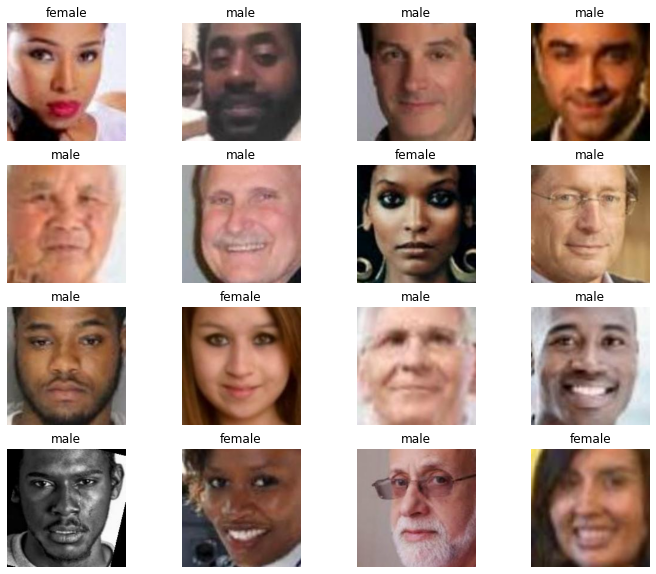

In [13]:
plt.figure(figsize=(12,10))

for en,i in enumerate(random.sample(range(1, 500), 16)):
    temp = cv2.imread(df['file'][i])
    label = df['gender'][i]
    plt.subplot(4,4,en+1);plt.imshow(temp[...,::-1]);plt.axis('off');plt.title(label);
print(temp.shape)

In [14]:
print('Gender Count in the dataset :\n',df['gender'].value_counts())
print('--------------------------------------')
print('Race Count in the dataset :\n',df['race'].value_counts())

Gender Count in the dataset :
 male      12391
female    11314
Name: gender, dtype: int64
--------------------------------------
Race Count in the dataset :
 white     10078
black      4526
indian     3975
asian      3434
others     1692
Name: race, dtype: int64


In [15]:
df.drop(['race','age'],axis=1,inplace=True)
df.head()

,gender,file
0,male,utkface_aligned_cropped/UTKFace/49_0_3_2017011...
1,male,utkface_aligned_cropped/UTKFace/55_0_3_2017011...
2,female,utkface_aligned_cropped/UTKFace/26_1_3_2017010...
3,female,utkface_aligned_cropped/UTKFace/26_1_3_2017010...
4,male,utkface_aligned_cropped/UTKFace/26_0_2_2017011...


### Data Distribution

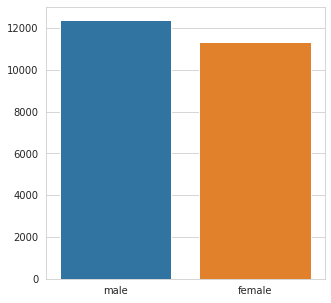

In [16]:
plt.figure(figsize=(5,5))
sns.set_style('whitegrid')
sns.barplot(y=df['gender'].value_counts().values.tolist(),x=df['gender'].value_counts().index.tolist())

In [17]:
# from sklearn.preprocessing import LabelEncoder
# enc = LabelEncoder()
# df['gender'] = enc.fit_transform(df['gender'])
x = df['file']
y = df['gender']

In [4]:
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
import os

### Initiating Image Data Generator

In [19]:
train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.0,
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")



### Splitting Train and Test Data

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)


In [21]:
train_df = pd.DataFrame()
train_df['file'] = X_train
train_df['gender'] = y_train
train_df = train_df.reset_index(drop=1)


test_df = pd.DataFrame()
test_df['file'] = X_test
test_df['gender'] = y_test
test_df = test_df.reset_index(drop=1)

In [22]:
print(train_df.shape)
train_df.head()


(21334, 2)


,file,gender
0,utkface_aligned_cropped/UTKFace/70_0_3_2017011...,male
1,utkface_aligned_cropped/UTKFace/9_0_0_20170110...,male
2,utkface_aligned_cropped/UTKFace/34_1_3_2017011...,female
3,utkface_aligned_cropped/UTKFace/25_1_2_2017010...,female
4,utkface_aligned_cropped/UTKFace/17_0_0_2017011...,male


In [23]:
print(test_df.shape)
test_df.head()


(2371, 2)


,file,gender
0,utkface_aligned_cropped/UTKFace/20_0_1_2017011...,male
1,utkface_aligned_cropped/UTKFace/50_0_0_2017011...,male
2,utkface_aligned_cropped/UTKFace/30_1_0_2017011...,female
3,utkface_aligned_cropped/UTKFace/1_1_2_20161219...,female
4,utkface_aligned_cropped/UTKFace/36_0_1_2017010...,male


### **Creating Train and Validation Data Generator**

In [24]:

train_generator = train_datagen.flow_from_dataframe(
                        color_mode = 'grayscale',
                        dataframe=train_df,
                        x_col='file',
                        y_col='gender',
                        subset="training",
                        batch_size=64,
                        seed=42,
                        shuffle=True,
                        class_mode="binary",
                        )

validation_generator = train_datagen.flow_from_dataframe(
                        color_mode = 'grayscale',
                        dataframe=train_df,
                        x_col='file',
                        y_col='gender',
                        subset="validation",
                        batch_size=64,
                        seed=42,
                        shuffle=True,
                        class_mode="binary",)

Found 16001 validated image filenames belonging to 2 classes.
Found 5333 validated image filenames belonging to 2 classes.


### **Designing Model to Classify Gender**

In [25]:
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same',input_shape=(256,256,1)))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(tf.keras.optimizers.Adam(lr=0.001),loss="binary_crossentropy",metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### **Training the Model - 30 Epochs**

In [26]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/30
250/250 [==============================] - 165s 534ms/step - loss: 0.7187 - accuracy: 0.6174 - val_loss: 5.6741 - val_accuracy: 0.5183
Epoch 2/30
250/250 [==============================] - 133s 530ms/step - loss: 0.6441 - accuracy: 0.6482 - val_loss: 2.7852 - val_accuracy: 0.4989
Epoch 3/30
250/250 [==============================] - 134s 534ms/step - loss: 0.6090 - accuracy: 0.6698 - val_loss: 1.5478 - val_accuracy: 0.5811
Epoch 4/30
250/250 [==============================] - 134s 537ms/step - loss: 0.5942 - accuracy: 0.6841 - val_loss: 0.8245 - val_accuracy: 0.5395
Epoch 5/30
250/250 [==============================] - 134s 537ms/step - loss: 0.5709 - accuracy: 0.7043 - val_loss: 0.9263 - val_accuracy: 0.5996
Epoch 6/30
250/250 [==============================] - 133s 533ms/step - loss: 0.5710 - accuracy: 0.7038 - val_loss: 0.6299 - val_accuracy: 0.6510
Epoch 7/30
250/250 [==============================] - 133s 533ms/step - loss: 0.5509 - accuracy: 0.7196 - val_loss: 0.7213 -

### **Creating Generator for Test Data**

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_dataframe(
              color_mode='grayscale',
              dataframe=test_df,
x_col="file",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None)

Found 2371 validated image filenames.


### **Mounting Drive for saving Model**

In [ ]:
from google.colab import drive
drive.mount('content/',force_remount=1)

Mounted at content/


### **Saving Model**

In [ ]:
model.save('content/MyDrive/gender/')

INFO:tensorflow:Assets written to: content/MyDrive/gender/assets


### **Saving Model.h5**

In [ ]:
model.save('content/MyDrive/gender/model_30.h5')

### **Model to Json**

In [7]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

### **Loading Saved Model**

In [5]:
from keras.models import load_model

model = load_model('gender-20211113T173628Z-001/gender/')

### **Model Summary**

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 activation (Activation)     (None, 256, 256, 16)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 32)        4

### **Model Inference**

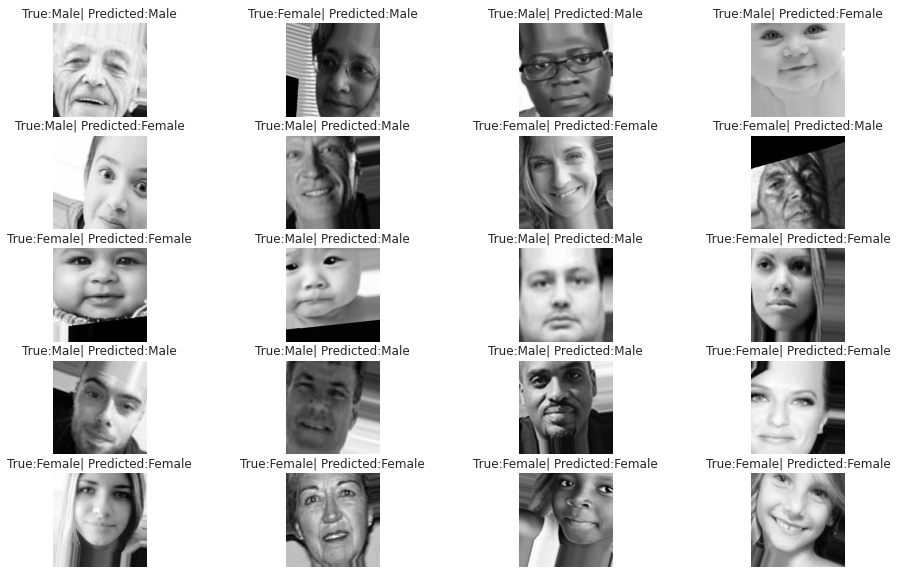

In [ ]:
n=20
plt.figure(figsize=(16,10))

label_dict = {1:'Male', 0:'Female'}


faces,label = next(train_generator)

for en,fl in enumerate(zip(faces,label)):
    if en==20:
      break
    f,l = fl 
    f = f.reshape(1,256,256,1)
    pred = round(model.predict(f)[0][0])

    f*=255
    f = f.reshape((256,256))
    plt.subplot(5,4,en+1);plt.imshow(f,cmap='gray');plt.axis('off');plt.title('True:'+label_dict[l]+'| Predicted:'+label_dict[pred]);
    

### **Model Inference on Unseen Data**

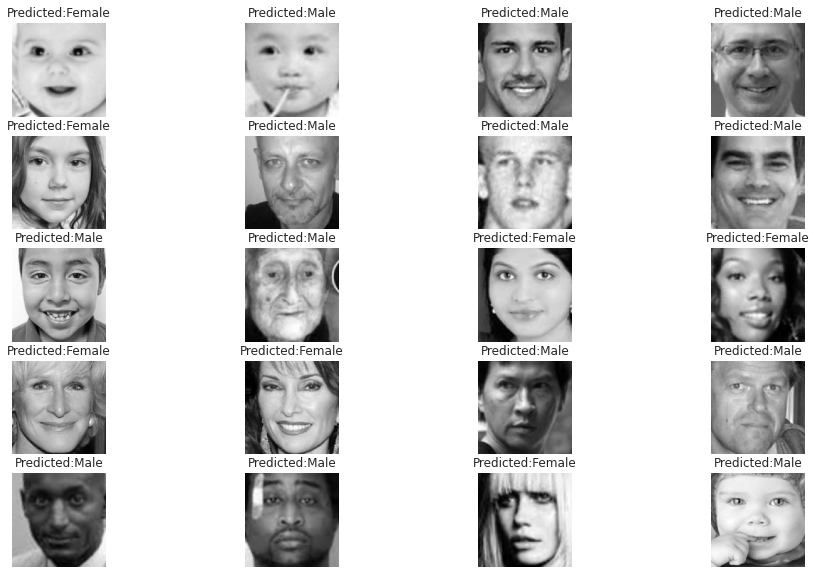

In [ ]:
n=20
plt.figure(figsize=(16,10))

label_dict = {1:'Male', 0:'Female'}

for i in range(n):
    f = next(test_generator)
    f = f.reshape(1,256,256,1)
    pred = round(model.predict(f)[0][0])

    f*=255
    f = f.reshape((256,256))
    plt.subplot(5,4,i+1);plt.imshow(f,cmap='gray');plt.axis('off');plt.title('Predicted:'+label_dict[pred]);
    

### **Model Evaluation**

In [ ]:
model.evaluate(validation_generator)

84/84 [==============================] - 44s 385ms/step - loss: 0.3376 - accuracy: 0.8509


[0.3375607132911682, 0.8509281873703003]

### **Saving Model History**

In [ ]:
np.save('gender_model_history.npy',history.history)

# history=np.load('my_history.npy',allow_pickle='TRUE').item()


### **Visualising Training Loss and Accuracy with each epoch**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


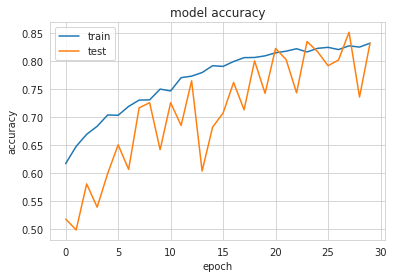

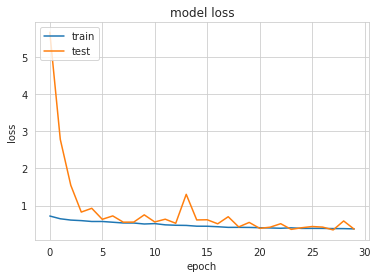

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
# list all data in training
print(history.history.keys())
# summarize training for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize traning for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **Real Time Gender Detection using our trained model and Haar cascade Frontal Face Detector**

In [9]:

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')  

cap = cv2.VideoCapture(0)

label_dict = {1:'Male', 0:'Female'}

while 1:
    
        ret, img = cap.read()
        img_bw = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        
        faces = face_cascade.detectMultiScale(img, 1.3, 5)
        
        for (x,y,w,h) in faces:
                cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
                face_roi = img_bw[y:y+h,x:x+w]
                face_roi = cv2.resize(face_roi,(256,256))
                face_roi = face_roi.reshape(1,256,256,1)
                pred = round(model.predict(face_roi)[0][0])
                face_roi = face_roi.reshape((256,256,1))
                cv2.putText(img,label_dict[pred],(x+20,y+h+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 2, cv2.LINE_AA) 
                
               
        cv2.imshow('img',img)
        if cv2.waitKey(1) == ord('q'):
            break
            
cap.release()
cv2.destroyAllWindows()

### **Visualising SIngle frame of gender detection**

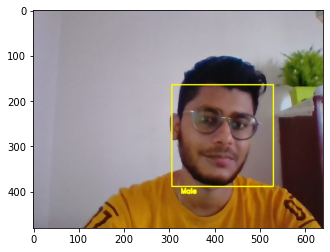

In [ ]:
plt.imshow(img[...,::-1])

In [ ]:
cap.release()
cv2.destroyAllWindows()